In [1]:
# Import the machine learning libraries.
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import PIL.Image
import time
import functools

import tensorflow as tf

In [2]:
# Load the input and style images.
folder_path = './'
target_image = folder_path + 'YellowLabradorLooking_new.jpg'
style_reference_image = folder_path + 'Vassily_Kandinsky,_1913_-_Composition_7.jpg'

content_path = target_image
style_path = style_reference_image

In [3]:
# Set up parameters.
max_dim = 512
content_layers = ['block5_conv2'] 
style_layers = ['block1_conv1',
          'block2_conv1',
          'block3_conv1', 
          'block4_conv1',
          'block5_conv1']

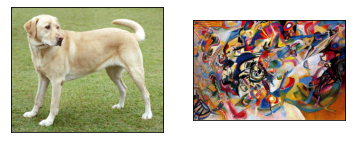

In [4]:
# Load and preprocess the image for VGG19.
def load_and_process_image(image_path):
  img = tf.keras.preprocessing.image.load_img(image_path)
  img = tf.keras.preprocessing.image.img_to_array(img)
  img = tf.image.resize(img, [max_dim,max_dim], preserve_aspect_ratio=True)
  img = tf.keras.applications.vgg19.preprocess_input(img)
  img = np.expand_dims(img, axis=0) 
  return img.copy()

# deprocess images
def deprocess(img): 
	# perform the inverse of the pre processing step 
	img[:, :, 0] += 103.939
	img[:, :, 1] += 116.779
	img[:, :, 2] += 123.68

	# convert RGB to BGR 
	img = img[:, :, ::-1] 
	img = np.clip(img, 0, 255).astype('uint8')
	return img 

# display images
def display_image(image): 
	# remove one dimension if image has 4 dimension 
	if len(image.shape) == 4: 
		img = np.squeeze(image, axis=0) 

	img = deprocess(img) 
	plt.grid(False) 
	plt.xticks([]) 
	plt.yticks([]) 
	plt.imshow(img) 
	return

# load content image 
content_img = load_and_process_image(content_path) 
style_img = load_and_process_image(style_path) 

# display input and style images.
plt.subplot(1, 2, 1)
display_image(content_img) 
plt.subplot(1, 2, 2)
display_image(style_img)

In [5]:
# Set up VGG19 model.
model = tf.keras.applications.VGG19( 
    include_top=False, 
    weights='imagenet'
) 
model.trainable = False  
model.summary()

80142336/80134624 [==============================] - 0s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
______________________________________________________________

In [6]:
# use Functional API to get intermediate layer output
# get content layers
content_model = tf.keras.Model(inputs=model.input,
                 outputs=[model.get_layer(layer).output for layer in content_layers])
content_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [7]:
# style layers output
style_models = [tf.keras.Model(inputs=model.input,outputs=model.get_layer(layer).output) for layer in style_layers] 
style_models[0].summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
Total params: 1,792
Trainable params: 0
Non-trainable params: 1,792
_________________________________________________________________


In [8]:
# Content loss 
# input content image, generated image
# formula(1) in the paper
def content_loss(content, generated):     
    F = content_model(content) 
    P = content_model(generated) 
    loss = 1/2 * (tf.keras.backend.sum(tf.keras.backend.square(F - P))) 
    #print("F",F.shape)
    #print("P",P.shape)
    return loss 

# gram matrix 
# by defintion A dot AT
def gram_matrix(A): 
    #x = tf.squeeze(A) 
    #x = tf.reshape(x, [x.shape[2], x.shape[0] * x.shape[1]]) 
    #gram = tf.matmul(x, x, transpose_a=True) 
    x = A
    gram = tf.linalg.einsum('bijc,bijd->bcd', x, x)
    gram = tf.squeeze(gram)
    input_shape = tf.shape(A)
    return gram   
  
# style loss 
# input content image, generated image
# formula(4) in the paper
def style_loss(style, generated):
    layer_style_weight = 1/len(style_layers)
    style_loss = 0
  
    for x in range(0,len(style_layers)):
        layer = style_models[x]
        N = layer.output_shape[3] # number of filters in the layer
        M = content_img.shape[1] * content_img.shape[2] # layers' height * width 
        A = layer(style) 
        G = layer(generated)  
        GA = gram_matrix(A) 
        GG = gram_matrix(G) 
    
        current_loss =  1.0 / float((2*N*M)**2) * tf.keras.backend.sum(tf.keras.backend.square(GG - GA))
        style_loss += layer_style_weight * current_loss 
  
    return style_loss

In [9]:
# Training function
def training_loop(content_path, style_path, epoch = 10, iterations=100,lr=10, a=10, b=1000): 
    content = load_and_process_image(content_path)
    style = load_and_process_image(style_path) 
    
    # generate white noise image
    generated = np.random.uniform(0, 255, (1, content.shape[1], content.shape[2], 3)) - 128 
    generated = tf.Variable(content, dtype=tf.float32) 

    # I used optimizer use Adam optimizer in this implementation
    opt = tf.keras.optimizers.Adam(learning_rate=lr, beta_1=0.99, epsilon=1e-1)
    best_cost = float('inf') 
    best_image = None
    for e in range(epoch):
      print("Epoch :{}".format(e),"start") 
      for i in range(iterations): 
        with tf.GradientTape() as tape: 
            loss_content = content_loss(content, generated) 
            loss_style = style_loss(style, generated)
            loss_total = a * loss_content + b * loss_style 
  
        grads = tape.gradient(loss_total, generated) 
        opt.apply_gradients([(grads, generated)]) 
  
        if loss_total < best_cost: 
            best_cost = loss_total 
            best_image = generated.numpy() 

      print('Best Total Loss {:e}.'.format(best_cost))   
      print("Epoch :{}".format(e), "end") 
  
    return best_image

Epoch :0 start
Best Total Loss 1.046257e+11.
Epoch :0 end
Epoch :1 start
Best Total Loss 3.954478e+10.
Epoch :1 end
Epoch :2 start
Best Total Loss 1.976340e+10.
Epoch :2 end
Epoch :3 start
Best Total Loss 1.212952e+10.
Epoch :3 end
Epoch :4 start
Best Total Loss 7.958195e+09.
Epoch :4 end
Epoch :5 start
Best Total Loss 5.301853e+09.
Epoch :5 end
Epoch :6 start
Best Total Loss 3.557367e+09.
Epoch :6 end
Epoch :7 start
Best Total Loss 2.394755e+09.
Epoch :7 end
Epoch :8 start
Best Total Loss 1.630330e+09.
Epoch :8 end
Epoch :9 start
Best Total Loss 1.138858e+09.
Epoch :9 end
Epoch :10 start
Best Total Loss 8.274816e+08.
Epoch :10 end
Epoch :11 start
Best Total Loss 6.289009e+08.
Epoch :11 end
Epoch :12 start
Best Total Loss 5.004621e+08.
Epoch :12 end
Epoch :13 start
Best Total Loss 4.151334e+08.
Epoch :13 end
Epoch :14 start
Best Total Loss 3.579514e+08.
Epoch :14 end
Epoch :15 start
Best Total Loss 3.173477e+08.
Epoch :15 end
Epoch :16 start
Best Total Loss 2.878748e+08.
Epoch :16 end


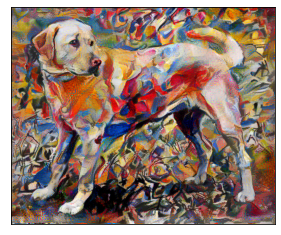

In [10]:
# Train the model and get best image.
final_img = training_loop(content_path, style_path,epoch = 40, iterations=1000,lr = 0.03, a =1, b = 100000) 
  
# plot best result 
display_image(final_img)